In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    classification_report,
    f1_score,
)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

from ucimlrepo import fetch_ucirepo

### Data & Visulisation

7 classes multi-class classification

581012 instances

54 features -> 44 features

In [2]:
# fetch dataset
covertype = fetch_ucirepo(id=31)

# data (as pandas dataframes)
X = covertype.data.features
y = covertype.data.targets

In [3]:
# class distribution
print(y.value_counts())

# print the percentage of each class
print(y.value_counts(normalize=True) * 100)

Cover_Type
2             283301
1             211840
3              35754
7              20510
6              17367
5               9493
4               2747
Name: count, dtype: int64
Cover_Type
2             48.759922
1             36.460521
3              6.153746
7              3.530048
6              2.989095
5              1.633873
4              0.472796
Name: proportion, dtype: float64


In [4]:
# Features to be removed before the model
# Hillshade_3pm - high correlation with Hillshade_9am and Hillshade_Noon
# Soily 7, 15, 37 - only one cover type
# other soils: low standard deviation
rem = [
    "Hillshade_3pm",
    "Soil_Type7",
    "Soil_Type8",
    "Soil_Type14",
    "Soil_Type15",
    "Soil_Type21",
    "Soil_Type25",
    "Soil_Type28",
    "Soil_Type36",
    "Soil_Type37",
]

X_clean = X.drop(rem, axis=1)

In [5]:
to_exclude_indices = [
    col
    for col in X_clean.columns
    if col.startswith("Soil_Type") or col.startswith("Wilderness_Area")
]
to_scale_indices = [
    col for col in X_clean.columns if col not in to_exclude_indices
]

In [6]:
col_to_scale = X_clean[to_scale_indices]
col_to_exclude = X_clean[to_exclude_indices]

# apply the standard scaler to the columns that are not soil type
scaler = StandardScaler()
scaled_cols = scaler.fit_transform(col_to_scale)

scaled_df = pd.DataFrame(scaled_cols, columns=to_scale_indices)

# combine the scaled columns with the columns that were excluded
X_scaled = pd.concat([scaled_df, col_to_exclude], axis=1)

X_scaled

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type38,Soil_Type39,Soil_Type40,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4
0,-1.297805,-0.935157,-1.482820,-0.053767,-0.796273,-1.180146,0.330743,0.439143,3.246283,1,...,0,0,0,0,0,0,0,0,0,0
1,-1.319235,-0.890480,-1.616363,-0.270188,-0.899197,-1.257106,0.293388,0.590899,3.205504,1,...,0,0,0,0,0,0,0,0,0,0
2,-0.554907,-0.148836,-0.681563,-0.006719,0.318742,0.532212,0.816364,0.742654,3.126965,1,...,0,0,0,0,0,0,0,0,0,0
3,-0.622768,-0.005869,0.520322,-0.129044,1.227908,0.474492,0.965786,0.742654,3.194931,1,...,0,0,0,0,0,0,0,0,0,0
4,-1.301377,-0.988770,-1.616363,-0.547771,-0.813427,-1.256464,0.293388,0.540313,3.165479,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,-2.012130,-0.023740,0.787408,-0.867697,-0.504653,-1.437962,1.040496,0.692069,-0.863386,0,...,0,0,0,0,0,0,0,0,1,0
581008,-2.029988,-0.032675,0.653865,-0.952383,-0.590424,-1.446299,1.040496,0.692069,-0.857345,0,...,0,0,0,0,0,0,0,0,1,0
581009,-2.047847,0.029873,0.386780,-0.985317,-0.676194,-1.449506,0.891075,0.894409,-0.850548,0,...,0,0,0,0,0,0,0,0,1,0
581010,-2.054990,0.128163,0.119694,-0.985317,-0.710502,-1.449506,0.666942,1.096749,-0.842997,0,...,0,0,0,0,0,0,0,0,1,0


In [7]:
# convert the dataframes to numpy arrays
X_np = X_scaled.to_numpy()
print(X_np.shape)
y_np = y.to_numpy().flatten() - 1
print(y_np.shape)

(581012, 44)
(581012,)


In [8]:
train_X, hold_out_test_X, train_y, hold_out_test_y = train_test_split(
    X_np, y_np, test_size=0.3, random_state=73, stratify=y_np
)

In [9]:
np.bincount(train_y), np.bincount(hold_out_test_y)

(array([148288, 198310,  25028,   1923,   6645,  12157,  14357]),
 array([63552, 84991, 10726,   824,  2848,  5210,  6153]))

### Common code

In [10]:
# Config
NUM_FOLD = 5
RANDOM_STATE = 73

In [11]:
def get_fold_print_string(fold_result: list[float]):
    mean = np.mean(fold_result)
    ste = np.std(fold_result) / np.sqrt(NUM_FOLD)
    return f"{mean:.3f} ± {ste:.3f}"

In [12]:
def multiclass_classification(
    model,
    model_name: str,
    n_splits: int = NUM_FOLD,
    random_state: int = RANDOM_STATE,
):
    print(f"Model {model_name} with {n_splits}-fold cross-validation\n")
    skf = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=random_state
    )

    fold_accuracy = []
    fold_f1 = []

    hold_out_accuracy = []
    hold_out_f1 = []

    fig, ax = plt.subplots(1, 5, figsize=(15, 4))
    for i, (train_index, test_index) in enumerate(skf.split(train_X, train_y)):
        model.fit(train_X[train_index], train_y[train_index])

        y_pred = model.predict(train_X[test_index])

        acc = accuracy_score(train_y[test_index], y_pred)
        fold_accuracy.append(acc)

        f1 = f1_score(train_y[test_index], y_pred, average="weighted")
        fold_f1.append(f1)

        print(classification_report(train_y[test_index], y_pred))

        # Test on hold-out test set
        y_hold_out_pred = model.predict(hold_out_test_X)

        acc = accuracy_score(hold_out_test_y, y_hold_out_pred)
        hold_out_accuracy.append(acc)

        f1 = f1_score(hold_out_test_y, y_hold_out_pred, average="weighted")
        hold_out_f1.append(f1)

        print("Hold-out Test")
        print(classification_report(hold_out_test_y, y_hold_out_pred))

        # Plot confusion matrix
        cm = confusion_matrix(train_y[test_index], y_pred)
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels=model.classes_
        )
        disp.plot(ax=ax[i], xticks_rotation=45)
        ax[i].set_title(f"Fold {i}")

    print("\nCross-Validation Results:")
    print(f"Mean Accuracy: {get_fold_print_string(fold_accuracy)}")
    print(f"Mean F1: {get_fold_print_string(fold_f1)}")

    print("\nHold-out Test Results:")
    print(f"Mean Accuracy: {get_fold_print_string(hold_out_accuracy)}")
    print(f"Mean F1: {get_fold_print_string(hold_out_f1)}")

    plt.tight_layout()

## Logistic regression

Model Logistic Regression with 5-fold cross-validation



/home/kg3217/miniconda3/envs/phd/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0       0.71      0.70      0.71     29658
           1       0.75      0.80      0.78     39662
           2       0.68      0.82      0.74      5006
           3       0.66      0.45      0.53       385
           4       0.19      0.01      0.01      1329
           5       0.50      0.24      0.32      2431
           6       0.72      0.57      0.64      2871

    accuracy                           0.73     81342
   macro avg       0.60      0.51      0.53     81342
weighted avg       0.71      0.73      0.72     81342

Hold-out Test
              precision    recall  f1-score   support

           0       0.71      0.70      0.71     63552
           1       0.75      0.80      0.77     84991
           2       0.67      0.82      0.74     10726
           3       0.62      0.43      0.51       824
           4       0.23      0.01      0.02      2848
           5       0.49      0.22      0.30      5210
          

/home/kg3217/miniconda3/envs/phd/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0       0.71      0.69      0.70     29658
           1       0.75      0.80      0.77     39662
           2       0.67      0.82      0.74      5006
           3       0.62      0.43      0.50       385
           4       0.26      0.01      0.01      1329
           5       0.50      0.22      0.30      2431
           6       0.72      0.56      0.63      2871

    accuracy                           0.72     81342
   macro avg       0.60      0.50      0.52     81342
weighted avg       0.71      0.72      0.71     81342

Hold-out Test
              precision    recall  f1-score   support

           0       0.71      0.70      0.70     63552
           1       0.75      0.80      0.77     84991
           2       0.67      0.82      0.74     10726
           3       0.62      0.43      0.51       824
           4       0.12      0.00      0.01      2848
           5       0.49      0.22      0.30      5210
          

/home/kg3217/miniconda3/envs/phd/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0       0.71      0.69      0.70     29658
           1       0.75      0.80      0.77     39662
           2       0.67      0.82      0.74      5006
           3       0.67      0.43      0.52       385
           4       0.21      0.01      0.01      1329
           5       0.44      0.21      0.28      2431
           6       0.71      0.56      0.63      2871

    accuracy                           0.72     81342
   macro avg       0.59      0.50      0.52     81342
weighted avg       0.71      0.72      0.71     81342

Hold-out Test
              precision    recall  f1-score   support

           0       0.71      0.70      0.70     63552
           1       0.75      0.80      0.77     84991
           2       0.67      0.82      0.74     10726
           3       0.63      0.43      0.51       824
           4       0.14      0.00      0.01      2848
           5       0.48      0.22      0.31      5210
          

/home/kg3217/miniconda3/envs/phd/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0       0.71      0.69      0.70     29657
           1       0.75      0.80      0.77     39662
           2       0.67      0.81      0.74      5005
           3       0.64      0.43      0.51       384
           4       0.20      0.01      0.01      1329
           5       0.48      0.23      0.31      2432
           6       0.72      0.55      0.62      2872

    accuracy                           0.72     81341
   macro avg       0.59      0.50      0.52     81341
weighted avg       0.71      0.72      0.71     81341

Hold-out Test
              precision    recall  f1-score   support

           0       0.71      0.70      0.71     63552
           1       0.75      0.80      0.77     84991
           2       0.67      0.82      0.74     10726
           3       0.63      0.43      0.51       824
           4       0.20      0.01      0.01      2848
           5       0.49      0.23      0.31      5210
          

/home/kg3217/miniconda3/envs/phd/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0       0.71      0.70      0.70     29657
           1       0.75      0.80      0.77     39662
           2       0.67      0.82      0.74      5005
           3       0.63      0.42      0.50       384
           4       0.30      0.01      0.02      1329
           5       0.47      0.22      0.30      2432
           6       0.73      0.56      0.63      2872

    accuracy                           0.72     81341
   macro avg       0.61      0.50      0.52     81341
weighted avg       0.71      0.72      0.71     81341

Hold-out Test
              precision    recall  f1-score   support

           0       0.71      0.70      0.71     63552
           1       0.75      0.80      0.77     84991
           2       0.67      0.82      0.74     10726
           3       0.63      0.43      0.51       824
           4       0.15      0.01      0.01      2848
           5       0.48      0.22      0.30      5210
          

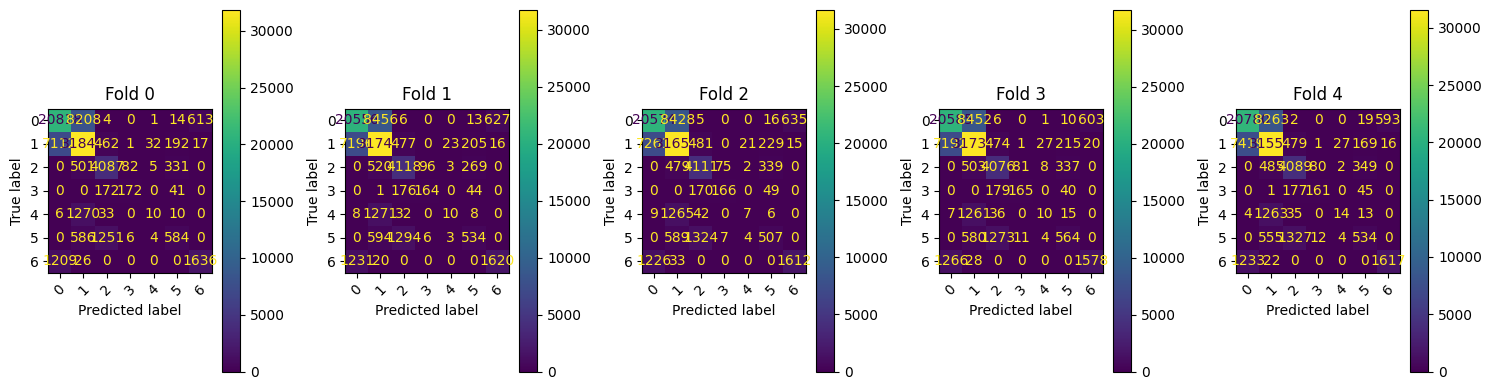

In [13]:
model = LogisticRegression(solver="saga")
multiclass_classification(model, "Logistic Regression")

## Random forest

Model Random Forest with 5-fold cross-validation

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     29658
           1       0.95      0.97      0.96     39662
           2       0.94      0.96      0.95      5006
           3       0.91      0.89      0.90       385
           4       0.93      0.74      0.83      1329
           5       0.92      0.89      0.90      2431
           6       0.98      0.94      0.96      2871

    accuracy                           0.95     81342
   macro avg       0.94      0.90      0.92     81342
weighted avg       0.95      0.95      0.95     81342

Hold-out Test
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     63552
           1       0.95      0.97      0.96     84991
           2       0.93      0.96      0.95     10726
           3       0.92      0.84      0.88       824
           4       0.94      0.75      0.83      2848
           5  

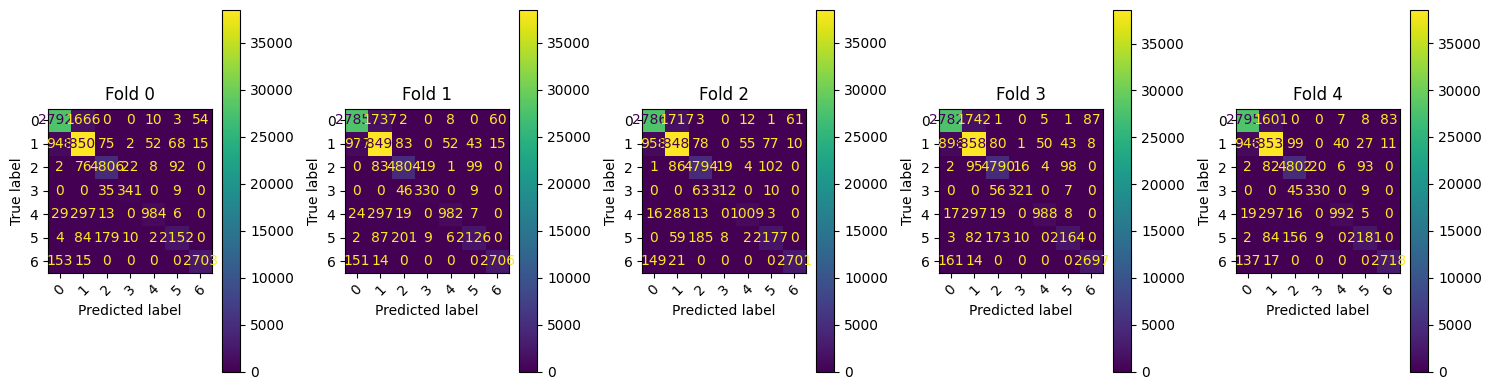

In [14]:
model = RandomForestClassifier(n_estimators=100, random_state=75)
multiclass_classification(model, "Random Forest")

## SVM

Model SVM with 5-fold cross-validation

              precision    recall  f1-score   support

           0       0.70      0.67      0.68     29658
           1       0.78      0.70      0.74     39662
           2       0.63      0.68      0.65      5006
           3       0.35      0.64      0.46       385
           4       0.21      0.35      0.26      1329
           5       0.31      0.48      0.38      2431
           6       0.47      0.82      0.60      2871

    accuracy                           0.68     81342
   macro avg       0.49      0.62      0.54     81342
weighted avg       0.71      0.68      0.69     81342

Hold-out Test
              precision    recall  f1-score   support

           0       0.69      0.66      0.68     63552
           1       0.78      0.70      0.74     84991
           2       0.62      0.70      0.66     10726
           3       0.36      0.63      0.46       824
           4       0.20      0.35      0.26      2848
           5       0.32 

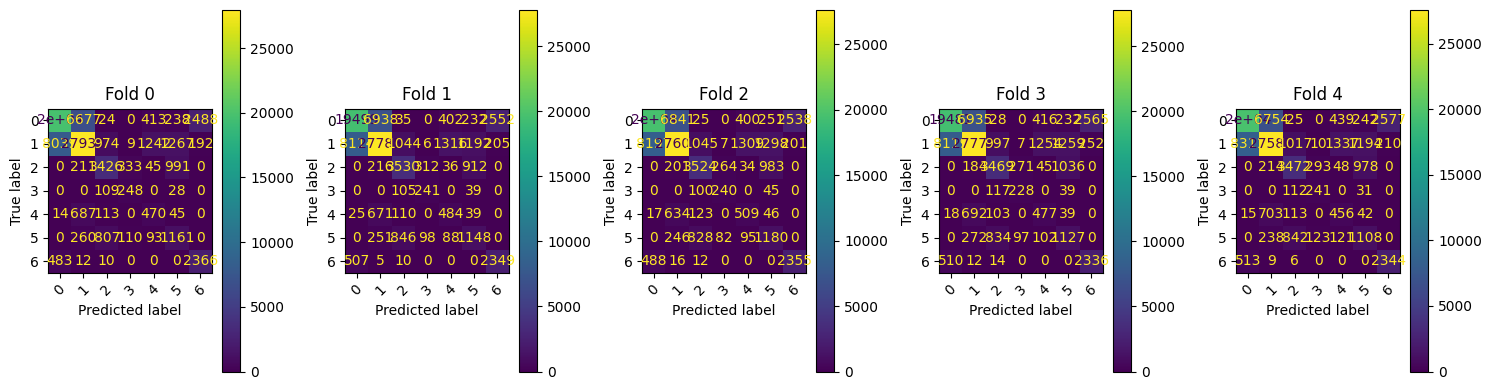

In [15]:
model = LinearSVC(random_state=76, class_weight="balanced")
multiclass_classification(model, "SVM")

## Decision tree

In [16]:
# Function to calculate the average depth of the decision tree
def average_tree_depth(tree):
    def _recursive_depth(node, current_depth, depths):
        if (
            tree.children_left[node] == tree.children_right[node]
        ):  # It's a leaf node
            depths.append(current_depth)
            return
        _recursive_depth(tree.children_left[node], current_depth + 1, depths)
        _recursive_depth(tree.children_right[node], current_depth + 1, depths)

    depths = []
    _recursive_depth(0, 0, depths)  # Start from the root node (index 0)
    return sum(depths) / len(depths)


# Function to count the number of branches (internal nodes)
def count_branches(tree):
    n_nodes = tree.node_count  # Total number of nodes in the tree
    n_leaves = tree.n_leaves  # Total number of leaf nodes
    n_branches = n_nodes - n_leaves  # Number of internal nodes (branches)
    return n_branches

Decision tree with 5-fold cross-validation

              precision    recall  f1-score   support

           0       0.92      0.93      0.92     29658
           1       0.94      0.93      0.94     39662
           2       0.91      0.91      0.91      5006
           3       0.84      0.81      0.82       385
           4       0.81      0.79      0.80      1329
           5       0.85      0.85      0.85      2431
           6       0.93      0.93      0.93      2871

    accuracy                           0.92     81342
   macro avg       0.89      0.88      0.88     81342
weighted avg       0.92      0.92      0.92     81342

Hold-out Test
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     63552
           1       0.93      0.94      0.94     84991
           2       0.91      0.91      0.91     10726
           3       0.83      0.82      0.83       824
           4       0.83      0.78      0.80      2848
           5       0

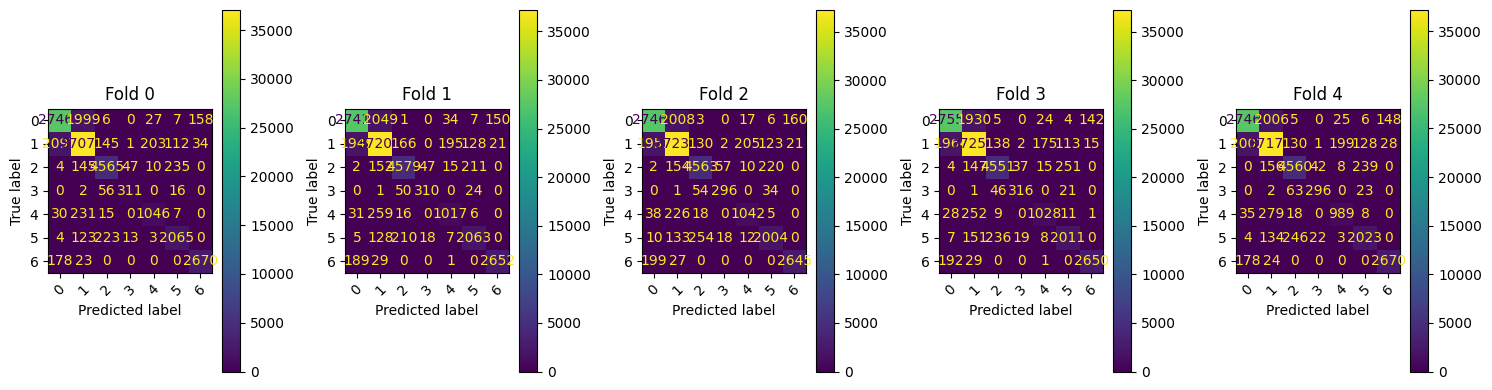

In [17]:
model = DecisionTreeClassifier(random_state=77, class_weight="balanced")
print(f"Decision tree with {NUM_FOLD}-fold cross-validation\n")
skf = StratifiedKFold(n_splits=NUM_FOLD, shuffle=True, random_state=77)

fold_accuracy = []
fold_f1 = []
tree_stats: list[dict[str, float]] = []
hold_out_accuracy = []
hold_out_f1 = []

fig, ax = plt.subplots(1, NUM_FOLD, figsize=(15, 4))
for i, (train_index, test_index) in enumerate(skf.split(train_X, train_y)):
    model.fit(train_X[train_index], train_y[train_index])

    y_pred = model.predict(train_X[test_index])

    acc = accuracy_score(train_y[test_index], y_pred)
    fold_accuracy.append(acc)

    f1 = f1_score(train_y[test_index], y_pred, average="weighted")
    fold_f1.append(f1)

    max_depth = model.get_depth()
    avg_depth = average_tree_depth(model.tree_)
    n_branches = count_branches(model.tree_)

    tree_stats.append(
        {
            "max_depth": max_depth,
            "avg_depth": avg_depth,
            "n_branches": n_branches,
        }
    )

    print(classification_report(train_y[test_index], y_pred))

    # Test on hold-out test set
    y_hold_out_pred = model.predict(hold_out_test_X)

    acc = accuracy_score(hold_out_test_y, y_hold_out_pred)
    hold_out_accuracy.append(acc)
    f1 = f1_score(hold_out_test_y, y_hold_out_pred, average="weighted")
    hold_out_f1.append(f1)
    print("Hold-out Test")
    print(classification_report(hold_out_test_y, y_hold_out_pred))

    # Plot confusion matrix
    cm = confusion_matrix(train_y[test_index], y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=model.classes_
    )
    disp.plot(ax=ax[i], xticks_rotation=45)
    ax[i].set_title(f"Fold {i}")

print("\nCross-Validation Results:")
print(f"Mean Accuracy: {get_fold_print_string(fold_accuracy)}")
print(f"Mean F1: {get_fold_print_string(fold_f1)}")

print("\nHold-out Test Results:")
print(f"Mean Accuracy: {get_fold_print_string(hold_out_accuracy)}")
print(f"Mean F1: {get_fold_print_string(hold_out_f1)}")

print(f"\nTree stats:")
print(
    f"Avg Max Depth: {get_fold_print_string([x['max_depth'] for x in tree_stats])}"
)
print(
    f"Avg Avg Depth: {get_fold_print_string([x['avg_depth'] for x in tree_stats])}"
)
print(
    f"Avg Branches: {get_fold_print_string([x['n_branches'] for x in tree_stats])}"
)

plt.tight_layout()